## What do we have in alphageometry:

below is the existing code that we can use it to convert a logical form (in string type) to a figure. So we just need to finish the code to randomly sample the logical forms (in another word, sample different txt below), which is missing in the current code base.

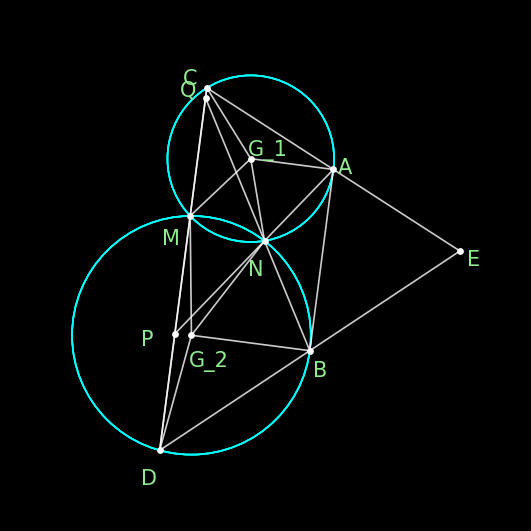

In [2]:
import graph as gh
import numericals as nm
from graph_test import *
import importlib
importlib.reload(nm)

txt = 'a b = segment a b; g1 = on_tline g1 a a b; g2 = on_tline g2 b b a; m = on_circle m g1 a, on_circle m g2 b; n = on_circle n g1 a, on_circle n g2 b; c = on_pline c m a b, on_circle c g1 a; d = on_pline d m a b, on_circle d g2 b; e = on_line e a c, on_line e b d; p = on_line p a n, on_line p c d; q = on_line q b n, on_line q c d ? cong e p e q'
defs = pr.Definition.from_txt_file('defs.txt', to_dict=True)
p = pr.Problem.from_txt(txt, translate=False)
g, _ = gh.Graph.build_problem(p, defs)
nm.draw(g.type2nodes[gh.Point],
g.type2nodes[gh.Line],
g.type2nodes[gh.Circle],
g.type2nodes[gh.Segment],
theme = 'dark')

## What we need to build next (an example):

we first load all the definitions from def.txt, which is a whole list of clauses we can posssibly sample

In [5]:
import problem as pr
DEFINITIONS = pr.Definition.from_txt_file('defs.txt', to_dict=True)

example: all points we need to construct a eqdistance clause. In this case, we need three points to build on. (we can change their name as we like)

In [4]:
DEFINITIONS['intersection_lc'].deps.points

['a', 'o', 'b']

now below are all the constraints for above points. This means that there is three constraint: 'a' and 'b' need to be different points, 'o' and 'b' need to be different points, 'b', 'o' and 'b', 'a' should not be perpendicular.

In [13]:
print(len(DEFINITIONS['intersection_lc'].deps.constructions))
print(DEFINITIONS['intersection_lc'].deps.constructions[0].name)
print(DEFINITIONS['intersection_lc'].deps.constructions[0].args)
print(DEFINITIONS['intersection_lc'].deps.constructions[1].name)
print(DEFINITIONS['intersection_lc'].deps.constructions[1].args)
print(DEFINITIONS['intersection_lc'].deps.constructions[2].name)
print(DEFINITIONS['intersection_lc'].deps.constructions[2].args)

3
diff
['a', 'b']
diff
['o', 'b']
nperp
['b', 'o', 'b', 'a']


How many possible clauses have no dependecies?

In [14]:
def_wo_deps = [d
               for d in DEFINITIONS.keys() 
               if len(DEFINITIONS[d].deps.points) == 0
               ]

print(len(def_wo_deps))
print(def_wo_deps)

17
['eq_quadrangle', 'eq_trapezoid', 'eqdia_quadrangle', 'free', 'iso_triangle', 'pentagon', 'quadrangle', 'r_trapezoid', 'r_triangle', 'rectangle', 'risos', 'segment', 'isquare', 'trapezoid', 'triangle', 'triangle12', 'ieq_triangle']


We can use all aboves to start the sampling. During the sampling, we need to use the current graph to list all possible next clause to sample.

Firstly, all above 17 clauses can be used to sample anytime.

Then we will go through all others one by one, take below as an example, we have established a segment:

In [27]:
txt = 'a b = segment a b'
defs = pr.Definition.from_txt_file('defs.txt', to_dict=True)
p = pr.Problem.from_txt(txt, translate=False)
g, _ = gh.Graph.build_problem(p, defs)

we want to build another 'on_tline' clause, constraint is we need two points different.

In [16]:
print(DEFINITIONS['on_tline'].deps.constructions[0].name)
print(DEFINITIONS['on_tline'].deps.constructions[0].args)

diff
['b', 'c']


check the graph, get all points in g for now:

In [17]:
all_points = g.type2nodes[gh.Point]
print([p.name for p in all_points])

['a', 'b']


In [18]:
g.check('diff', all_points[:2])

True

In [19]:
g.check('npara', [all_points[0], all_points[0], all_points[0], all_points[0]])

True

now we can add another 'on_tline' clause to the graph, using 'add_clause' function.

In [ ]:
new_clause_txt = 'g1 = on_tline g1 a a b'
# TODO: we need a programmatic way to get the above txt
new_clause = pr.Clause.from_txt(new_clause_txt)
g.add_clause(new_clause, 0, DEFINITIONS)
nm.draw(g.type2nodes[gh.Point],
g.type2nodes[gh.Line],
g.type2nodes[gh.Circle],
g.type2nodes[gh.Segment],
theme = 'dark')

make above procedure automatic

In [1]:
from itertools import product
import graph as gh
import numericals as nm
from graph_test import *

def draw_from_txt(txt):
    defs = pr.Definition.from_txt_file('defs.txt', to_dict=True)
    p = pr.Problem.from_txt(txt, translate=False)
    g, _ = gh.Graph.build_problem(p, defs)
    nm.draw(g.type2nodes[gh.Point],
    g.type2nodes[gh.Line],
    g.type2nodes[gh.Circle],
    g.type2nodes[gh.Segment],
    theme = 'dark')

# we here perform an additional check, avoiding some repetitive points.
def rep_check(restrition_name, lets):
    if restrition_name == 'nperp':
        if lets[0] == lets[1] or lets[2] == lets[3]:
            return False
    if restrition_name == 'npara':
        if lets[0] == lets[1] or lets[0] == lets[2] or lets[0] == lets[3] or lets[1] == lets[2] or lets[1] == lets[3] or lets[2] == lets[3]:
            return False
    if restrition_name == 'cong':
        if lets[0] == lets[1] or lets[2] == lets[3] or lets[1] == lets[3]:
            return False
    if restrition_name == 'perp':
        if lets[0] == lets[1] or lets[0] == lets[2] or lets[0] == lets[3] or lets[1] == lets[3] or lets[2] == lets[3]:
            return False
    return True

# this function will take a current graph as input, go through all definitions and return all possible new premises
def all_possible_clauses(g):
    existing_points = g.type2nodes[gh.Point]
    possible_defs = []
    for d in DEFINITIONS.keys():
        needed_points_def = DEFINITIONS[d].deps.points
        if len(needed_points_def) == 0:
            possible_defs.append({
                'name': d,
                'dep_points': []
            })
            continue
        num_needed_points = len(needed_points_def)
        # all possible points assignments
        all_possible_points_assignments = product(existing_points, repeat=num_needed_points)
        # a list of map, each map from point in definition (string) to actual point (gm.Point)
        all_possible_points_map = [dict(zip(needed_points_def, p)) for p in all_possible_points_assignments]
        # check all
        for map in all_possible_points_map:
            meet = 0
            # check each restriction
            for construction in DEFINITIONS[d].deps.constructions:
                restrition_name = construction.name
                restrition_points = [map[arg] for arg in construction.args]
                restrition_points_name = [map[arg].name for arg in construction.args]
                if g.check(restrition_name, restrition_points) and rep_check(restrition_name, restrition_points_name):
                    meet += 1
            if meet == len(DEFINITIONS[d].deps.constructions):
                possible_defs.append({
                    'name': d,
                    'dep_points': [p.name for p in map.values()]
                })
    return possible_defs

def draw_from_txt(txt):
    defs = pr.Definition.from_txt_file('defs.txt', to_dict=True)
    p = pr.Problem.from_txt(txt, translate=False)
    g, _ = gh.Graph.build_problem(p, defs)
    nm.draw(g.type2nodes[gh.Point],
    g.type2nodes[gh.Line],
    g.type2nodes[gh.Circle],
    g.type2nodes[gh.Segment],
    theme = 'dark')

a b = segment a b; g i r v = eq_trapezoid i r g v; t = intersection_tt t a g b g r v


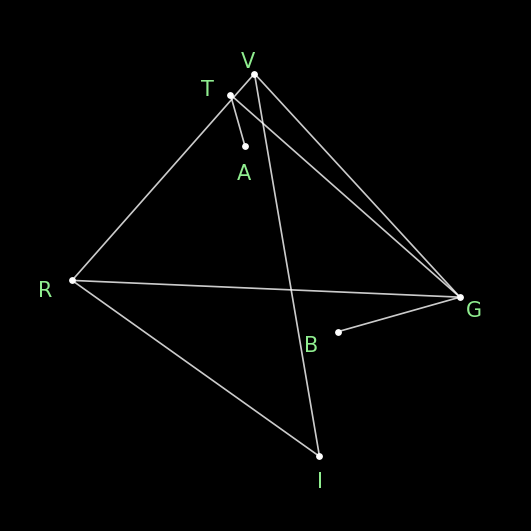

In [8]:
import random
import graph as gh
import numericals as nm
import problem as pr

letters = 'abcdefghijklmnopqrstuvwxyz'

# suppose we want 2 more clauses
num_new_clause = 2

txt = 'a b = segment a b'
DEFINITIONS = pr.Definition.from_txt_file('defs.txt', to_dict=True)
p = pr.Problem.from_txt(txt, translate=False)
g, _ = gh.Graph.build_problem(p, DEFINITIONS)

for i in range(num_new_clause):
    new_clause = random.choice(all_possible_clauses(g))
    existing_points = g.type2nodes[gh.Point]
    existing_letters = [p.name for p in existing_points]
    remaining_letters = [l for l in letters if l not in existing_letters]

    new_clause_def = DEFINITIONS[new_clause['name']]
    new_letters_in_def = list(set(new_clause_def.construction.args) - set(new_clause_def.deps.points))
    new_letters = random.sample(remaining_letters, len(new_letters_in_def))
    new_letters_map = dict(zip(new_letters_in_def, new_letters))

    dep_letters_in_defs = new_clause_def.deps.points
    dep_letters_in_real = new_clause['dep_points']
    dep_letters_map = dict(zip(dep_letters_in_defs, dep_letters_in_real))

    whole_letters_map = {**new_letters_map, **dep_letters_map}

    construction_name = new_clause_def.construction.name
    before_equal = ' '.join(new_letters)
    after_equal = ' '.join(
        whole_letters_map.get(name, name)
        for name in new_clause_def.construction.args
    )
    clause_text = f'{before_equal} = {construction_name} {after_equal}'
    txt = f'{txt}; {clause_text}'
    p = pr.Problem.from_txt(txt, translate=False)
    g, _ = gh.Graph.build_problem(p, DEFINITIONS)
print(txt)
draw_from_txt(txt)

for above, there are still some bugs on the code side to fix

There are still some problem unsolved in visualization:
1. Sometimes points get too close to the margin and the letters disappeared. (solved, we made everything annotation visiable)
2. We need to control the connection between the points. For example, when we build a triangle the three points are not connected. (this can be achieved by additionally_draw function in graph.py)
3. Getting additional annotations, such as for right angles.
4. Sometimes some positions are fixed, for example, when I'm building a triangle, the buttom line is always horizontal.

## shapes for priliminary experiments

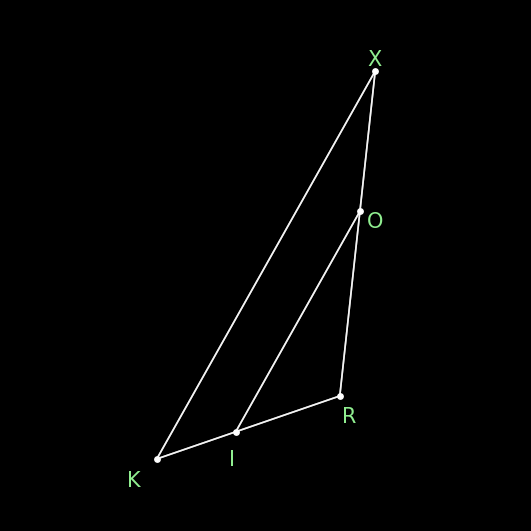

In [1]:
import numericals as nm
import problem as pr
import graph as gh
import importlib
import random
import string
import json
importlib.reload(nm)
importlib.reload(gh)

shape_data = [
    {
        'orcle_text': 'A B C = triangle A B C; D = on_line B C',
        'connection_list': 'AB, AC, AD'
    },
    {
        'orcle_text': 'A B C = triangle A B C; D = midpoint B C',
        'connection_list': 'AB, AC, AD'
    },
    {
        'orcle_text': 'A B C = triangle A B C; D = foot A B C',
        'connection_list': 'AB, AC, AD'
    },
    {
        'orcle_text': 'A B C = triangle A B C; D = on_line B C, angle_bisector B A C',
        'connection_list': 'AB, AC, AD'
    },
    {
        'orcle_text': 'A B C = triangle A B C; D = on_line A B; E = on_line A C, on_pline D B C',
        'connection_list': 'AB, AC, BC, DE'
    }
]

def generate_txt(letters, shape_data):
    letter_map = dict(zip(list(string.ascii_uppercase), letters))
    return shape_data['orcle_text'].translate(str.maketrans(letter_map))

def make_connection(letters, shape_data, g):
    letter_map = dict(zip(list(string.ascii_uppercase), letters))
    connections = shape_data['connection_list'].translate(str.maketrans(letter_map))
    connection_list = [i.strip() for i in connections.split(',')]
    for connection in connection_list:
        g.get_new_line_thru_pair(g._name2node[connection[0]], g._name2node[connection[1]])

def get_graph_from_shape(shape_data):
    letters = list(string.ascii_uppercase)
    random.shuffle(letters)
    txt = generate_txt(letters, shape_data)
    defs = pr.Definition.from_txt_file('defs.txt', to_dict=True)
    p = pr.Problem.from_txt(txt, translate=False)
    g, _ = gh.Graph.build_problem(p, defs)
    make_connection(letters, shape_data, g)
    return g

def draw_g(g):
    nm.draw(g.type2nodes[gh.Point],
    g.type2nodes[gh.Line],
    g.type2nodes[gh.Circle],
    g.type2nodes[gh.Segment],
    theme = 'dark',
    save_to='../test.png')

g = get_graph_from_shape(shape_data[4])
draw_g(g)